In [1]:
import os
import random
import math
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import pickle
from pprint import pprint

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
YEAR_START = 2020
RANGE = 380
TARGET_COUNTRIES = list()
COUNTRIES_TO_MISS = ['Djibouti', 'Mayotte', 'Réunion', 'Seychelles', 'Sao Tome and Principe', 'Cabo Verde', 'China, Macao SAR',
                     'Brunei Darussalam', 'Western Sahara', 'Cyprus', 'Bhutan', 'Maldives', 'Antigua and Barbuda', 'Aruba',
                     'Bahamas', 'Barbados', 'Curaçao', 'Grenada', 'Guadeloupe', 'Martinique', 'Saint Lucia', 'Saint Vincent and the Grenadines',
                     'United States Virgin Islands', 'Belize', 'French Guiana', 'Guyana', 'Suriname', 'Channel Islands', 'Iceland',
                     'Malta', 'Montenegro', 'Luxembourg']

df = pd.read_csv('data/country_groups.csv')
for column in df.columns:
    df[column] = [i if i not in COUNTRIES_TO_MISS else None for i in df[column]]
    tc = list(df[column].dropna())
    TARGET_COUNTRIES += tc

In [3]:
class Person:
    def __init__(self, year, fertility, lifespan, country, age):
        self.fertility = fertility
        self.lifespan = lifespan
        self.country = country
        self.birth_year = year - age
        self.age = age
        self.is_alive = True
        self.n_child = self.get_n_child()
        self.birth_ages = self.get_birth_ages()
        self.sex = self.get_sex()

    def iterate_year(self):
        if self.is_alive:
            self.age += 1

        if self.age >= self.lifespan:
            self.is_alive = False

        if self.sex == 'female' and self.age in self.birth_ages:
            return 'birth'

        return None

    def get_sex(self):
        sex = random.sample(['male', 'female'], 1)[0]
        return sex

    def get_n_child(self):
        down = int(self.fertility)
        up = math.ceil(self.fertility)
        weight = self.fertility - int(self.fertility)
        if weight == 0:
            return int(self.fertility)

        n_child = random.choices([down, up], weights=(weight, 1 - weight), k=1)[0]
        return n_child

    def get_random_birth_age(self):
        return int(np.random.normal(loc=28, scale=5))

    def get_birth_ages(self):
        lst = list()
        for i in range(self.n_child):
            lst.append(self.get_random_birth_age())

        return lst


class Dataset:
    def __init__(self):
        self.df = self.load_dataset()

    def load_dataset(self):
        df = pd.read_csv('data/WPP2019_POP_F07_1_POPULATION_BY_AGE_BOTH_SEXES.csv')
        df = df.rename(columns={'Region, subregion, country or area *': 'country'})
        target_columns = [i for i in df.columns if '-' in i] + ['country']
        df = df[df['Reference date (as of 1 July)'] == YEAR_START]
        df = df[target_columns]
        df = df[df['country'].isin(TARGET_COUNTRIES)]
        return df


class CountryData:
    def __init__(self):
        self.fertility = None

    def load_dataset(self):
        self.df = pd.read_csv('data/WPP2019_FERT_F04_TOTAL_FERTILITY.csv')
        self.df = self.df.rename(columns={'Region, subregion, country or area *': 'country'})

    def create_mapping(self):
        self.fertility = dict()
        for country, fertility_ in zip(self.df['country'], self.df['2015-2020']):
            self.fertility[country] = fertility_

    def get_lifespan(self, year, country):
        fertility = self.get_fertility(year, country)
        lifespan = 90 - 1 * (fertility ** 2) + (year - 2020) / 4
        return int(np.random.normal(loc=lifespan, scale=8))

    def get_fertility(self, year, country):
        coef = 0.99 ** (year - YEAR_START)
        fertility = self.fertility[country] * coef
        return fertility


class Population:
    def __init__(self):
        self.year = YEAR_START
        self.persons = list()
        self.country_data = CountryData()
        self.country_data.load_dataset()
        self.country_data.create_mapping()
        pass

    def get_age_by_age_group(self, age_group: str):
        age_group = age_group.split('-')
        age_group = [int(i) for i in age_group]
        age_group = range(age_group[0], age_group[1] + 1)
        age = random.sample(age_group, 1)[0]
        return age

    def load_current_population(self, dataset):
        df = dataset.df
        for country, group in df.groupby('country'):
            if country in COUNTRIES_TO_MISS:
                continue

            age_groups = [i for i in df.columns if '-' in i]
            fertility = self.country_data.get_fertility(YEAR_START, country)

            for age_group in age_groups:
                pop = list(group[age_group])[0]
                pop = [i for i in pop if i.isdigit()]
                pop = ''.join(pop)
                pop = int(int(pop) / 100)

                for _ in range(pop):
                    lifespan = self.country_data.get_lifespan(YEAR_START, country)
                    age = self.get_age_by_age_group(age_group)
                    p = Person(YEAR_START, fertility, lifespan, country, age)
                    self.persons.append(p)

    def print_age_distribution(self):
        print(f'length = {len([i.age for i in self.persons if i.is_alive])}')
        print(Counter([i.age for i in self.persons if i.is_alive]).most_common())

    def get_n_alive(self, country):
        n_alive = sum([1 for i in self.persons if i.is_alive and i.country == country])
        return n_alive

    def get_n_alive_by_age(self, country, age_min, age_max):
        n_alive = sum([1 for i in self.persons if i.is_alive and i.country == country and age_min <= i.age < age_max])
        return n_alive

    def get_n_alive_by_year(self, age_min: int = 0, age_max: int = 140) -> dict:
        n_alive = dict()
        for i in self.persons:
            country = i.country
            year_birth = i.birth_year
            year_death = i.birth_year + i.lifespan

            if country not in n_alive:
                n_alive[country] = dict()

            for year in range(year_birth, year_death):
                if not YEAR_START <= year < YEAR_START + RANGE:
                    continue

                if not age_min <= year - year_birth <= age_max:
                    continue

                if year not in n_alive[country]:
                    n_alive[country][year] = 0

                n_alive[country][year] += 1

        for country in n_alive:
            n_alive[country] = dict(sorted(n_alive[country].items()))
            for year in range(YEAR_START, YEAR_START + RANGE):
                if year not in n_alive[country]:
                    n_alive[country][year] = 0

                n_alive[country][year] = n_alive[country][year] / 10000

        return n_alive

    def get_fertility_data(self, year_start, year_end, country):
        fertility_data = [round(self.country_data.get_fertility(i, country), 2) for i in range(year_start, year_end + 1)]
        return fertility_data

    def iterate_year(self):
        print(f'\r{self.year}', end='')
        for person in self.persons:
            status = person.iterate_year()
            if status == 'birth':
                lifespan = self.country_data.get_lifespan(self.year, person.country)
                fertility = self.country_data.get_fertility(self.year, person.country)
                newborn = Person(self.year, fertility, lifespan, person.country, -1)
                self.persons.append(newborn)

        self.year += 1


class CountryGroups:
    def __init__(self):
        self.colors = None
        self.countries = None

    def create_colors(self):
        colormaps = [matplotlib.cm.get_cmap('Greys'),  # SUB-SAHARAN AFRICA
                     matplotlib.cm.get_cmap('Reds'),  # EASTERN AND SOUTH-EASTERN ASIA
                     matplotlib.cm.get_cmap('Greens'),  # CENTRAL AND SOUTHERN ASIA
                     matplotlib.cm.get_cmap('Oranges'),  # NORTHERN AFRICA AND WESTERN ASIA
                     matplotlib.cm.get_cmap('Purples'),  # LATIN AMERICA AND THE CARIBBEAN
                     matplotlib.cm.get_cmap('Blues')]  # EUROPE AND NORTHERN AMERICA

        self.colors = list()
        self.countries = list()

        for colormap, country_group in zip(colormaps, df.columns):
            country_group = df[country_group].dropna()

            for n, country in enumerate(country_group):
                add = len(country_group) / 5
                color = colormap((n + add) / (len(country_group) + add))  # escape white colors
                self.colors.append(color)
                self.countries.append(country)


In [4]:
def pickles():
    if f'population_{RANGE}.pickle' in os.listdir():
        print('pickle found, loading...')
        with open(f'population_{RANGE}.pickle', 'rb') as f:
            population = pickle.load(f)

        return population


population = pickles()
if not population:
    print('Pickle not found! Calculating...')
    dataset = Dataset()
    population = Population()
    population.load_current_population(dataset)
    [population.iterate_year() for i in range(RANGE)]

    with open(f'population_{RANGE}.pickle', 'wb') as f:
        pickle.dump(population, f)


Pickle not found! Calculating...
2399

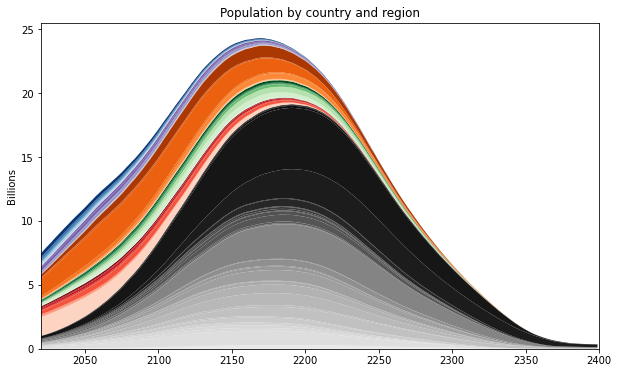

In [14]:
country_groups = CountryGroups()
country_groups.create_colors()

n_alive = population.get_n_alive_by_year()
stack = [list(n_alive[country].values()) for country in country_groups.countries]
plt.figure(figsize=[10, 6])
plt.stackplot(range(YEAR_START, YEAR_START + RANGE), stack, labels=country_groups.countries, colors=country_groups.colors)
plt.xlim([2020, 2020 + RANGE])
plt.title('Population by country and region')
plt.ylabel('Billions')
plt.savefig('charts/stack.png', bbox_inches='tight', dpi=300, facecolor='white')

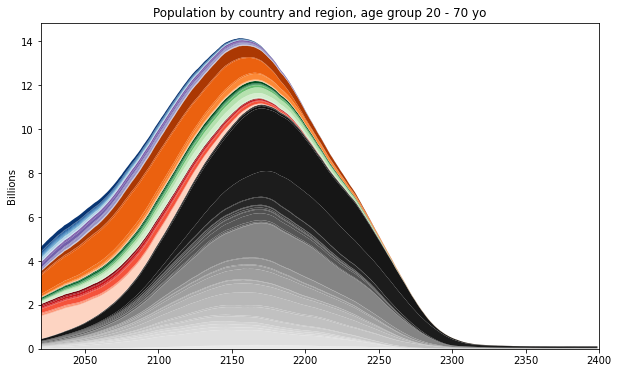

In [15]:
country_groups = CountryGroups()
country_groups.create_colors()

n_alive = population.get_n_alive_by_year(age_min=20, age_max=70)
stack = [list(n_alive[country].values()) for country in country_groups.countries]
plt.figure(figsize=[10, 6])
plt.stackplot(range(YEAR_START, YEAR_START + RANGE), stack, labels=country_groups.countries, colors=country_groups.colors)
plt.xlim([2020, 2020 + RANGE])
plt.title('Population by country and region, age group 20 - 70 yo')
plt.ylabel('Billions')
plt.savefig('charts/stack_20-70.png', bbox_inches='tight', dpi=300, facecolor='white')

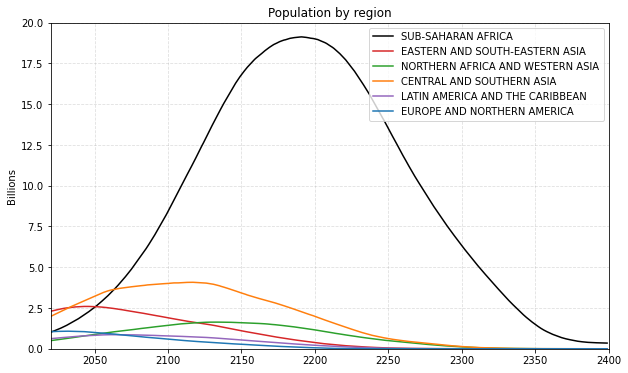

In [16]:
n_alive = population.get_n_alive_by_year()

plt.figure(figsize=[10, 6])
n_alive_country_group = dict()
for country_group in df.columns:
    n_alive_country_group[country_group] = dict()
    for country in df[country_group].dropna():
        for year in range(YEAR_START, YEAR_START + RANGE):
            if year not in n_alive_country_group[country_group]:
                n_alive_country_group[country_group][year] = 0

            n_alive_country_group[country_group][year] += n_alive[country][year]

    n_alive_country_group[country_group] = dict(sorted(n_alive_country_group[country_group].items()))

colors = ['k', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:blue']
for country_group, color in zip(df.columns, colors):
    plt.plot(range(YEAR_START, YEAR_START + RANGE), n_alive_country_group[country_group].values(), label=country_group, color=color)

plt.legend()
plt.title('Population by region')
plt.ylabel('Billions')
plt.xlim([2020, 2400])
plt.ylim([0, 20])
plt.grid(linestyle='--', alpha=0.4)
plt.savefig('charts/population.png', bbox_inches='tight', dpi=300, facecolor='white')

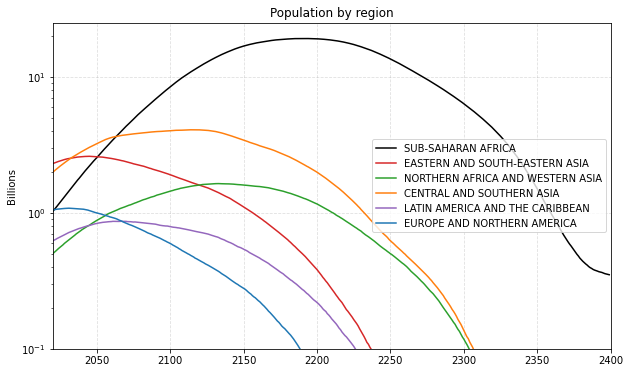

In [17]:
n_alive = population.get_n_alive_by_year()

plt.figure(figsize=[10, 6])
n_alive_country_group = dict()
for country_group in df.columns:
    n_alive_country_group[country_group] = dict()
    for country in df[country_group].dropna():
        for year in range(YEAR_START, YEAR_START + RANGE):
            if year not in n_alive_country_group[country_group]:
                n_alive_country_group[country_group][year] = 0

            n_alive_country_group[country_group][year] += n_alive[country][year]

    n_alive_country_group[country_group] = dict(sorted(n_alive_country_group[country_group].items()))

colors = ['k', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:blue']
for country_group, color in zip(df.columns, colors):
    plt.plot(range(YEAR_START, YEAR_START + RANGE), n_alive_country_group[country_group].values(), label=country_group, color=color)

plt.legend()
plt.title('Population by region')
plt.ylabel('Billions')
plt.xlim([2020, 2400])
plt.ylim([0.1, 25])
plt.yscale('log')
plt.grid(linestyle='--', alpha=0.4)
plt.savefig('charts/population_log.png', bbox_inches='tight', dpi=300, facecolor='white')

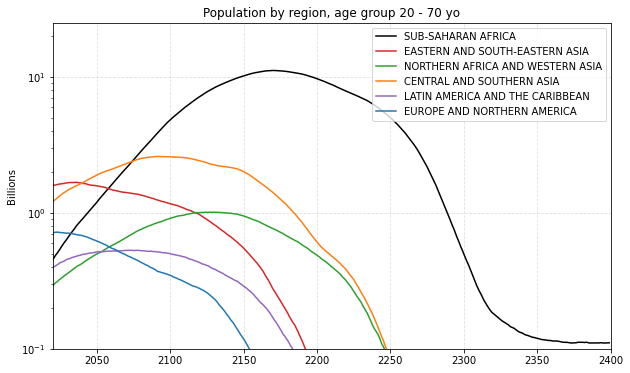

In [18]:
n_alive = population.get_n_alive_by_year(age_min=20, age_max=70)

plt.figure(figsize=[10, 6])
n_alive_country_group = dict()
for country_group in df.columns:
    n_alive_country_group[country_group] = dict()
    for country in df[country_group].dropna():
        for year in range(YEAR_START, YEAR_START + RANGE):
            if year not in n_alive_country_group[country_group]:
                n_alive_country_group[country_group][year] = 0

            n_alive_country_group[country_group][year] += n_alive[country][year]

    n_alive_country_group[country_group] = dict(sorted(n_alive_country_group[country_group].items()))

colors = ['k', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:blue']
for country_group, color in zip(df.columns, colors):
    plt.plot(range(YEAR_START, YEAR_START + RANGE), n_alive_country_group[country_group].values(), label=country_group, color=color)

plt.legend()
plt.title('Population by region, age group 20 - 70 yo')
plt.ylabel('Billions')
plt.xlim([2020, 2400])
plt.ylim([0.1, 25])
plt.yscale('log')
plt.grid(linestyle='--', alpha=0.4)
plt.savefig('charts/population_log_20-70.png', bbox_inches='tight', dpi=300, facecolor='white')